In [1]:
!wget "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

--2025-10-19 16:10:09--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.001s  

2025-10-19 16:10:09 (60.6 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [10]:
for col in df.columns:
    print(f'{col}:\t{df.dtypes[col]}')

lead_source:	object
industry:	object
number_of_courses_viewed:	int64
annual_income:	float64
employment_status:	object
location:	object
interaction_count:	int64
lead_score:	float64
converted:	int64


In [57]:
categorical=[]
numerical=[]
for col in df.columns:
    if df[col].dtypes=='object':
        categorical.append(col)
    elif df[col].dtypes in ['float64', 'int64']:
        numerical.append(col)


In [58]:
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [61]:
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [60]:
numerical.pop(4)

'converted'

In [24]:
for col in categorical:
    df[col]=df[col].fillna('NA')
for col in numerical:
    df[col]=df[col].fillna(0)

In [62]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
df_full_train, df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train, df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)


In [65]:
len(df)

1462

In [66]:
len(df_full_train), len(df_train), len(df_test), len(df_val)

(1169, 876, 293, 293)

In [67]:
1169/1462

0.7995896032831737

In [68]:
876/1462

0.5991792065663475

In [69]:
293/1462

0.20041039671682626

In [70]:
from sklearn.metrics import roc_auc_score

In [71]:
y_train=df_train['converted'].values
for col in numerical:
    auc=roc_auc_score(y_train,df_train[col])
    if auc<0.5:
        auc=roc_auc_score(y_train,-df_train[col])
    print(f'{col}:{auc}')
#negative correlation can be informative, but not auc=0.5 (random)

number_of_courses_viewed:0.7635680590007088
annual_income:0.5519578313253012
interaction_count:0.738270176293409
lead_score:0.6144993577250176


In [72]:
from sklearn.feature_extraction import DictVectorizer

In [73]:
from sklearn.linear_model import LogisticRegression

In [74]:
df_train.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
462,events,manufacturing,2,95543.0,unemployed,europe,3,0.78,0
135,referral,NA,1,54924.0,student,south_america,6,0.39,1
117,organic_search,healthcare,2,77352.0,unemployed,europe,2,0.22,0
1051,paid_ads,other,2,34600.0,employed,south_america,2,0.31,0
945,paid_ads,education,0,43615.0,unemployed,south_america,2,0.01,0


In [78]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.drop(columns=['converted']).to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val.drop(columns=['converted']).to_dict(orient='records')
X_val=dv.transform(val_dict)

y_train=df_train['converted'].values
y_val=df_val['converted'].values

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_val_pred=model.predict_proba(X_val)[:,1]
auc=roc_auc_score(y_val,y_val_pred)

print(round(auc,3))

0.817


In [80]:
from sklearn.metrics import precision_score, recall_score

In [91]:
threshold = np.arange(0.0, 1.01, 0.01) 

In [94]:
precision_values = []
recall_values = []

for t in threshold:
    y_pred_class = (y_val_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred_class, zero_division=0)
    recall = recall_score(y_val, y_pred_class, zero_division=0)
    
    precision_values.append(precision)
    recall_values.append(recall)
    


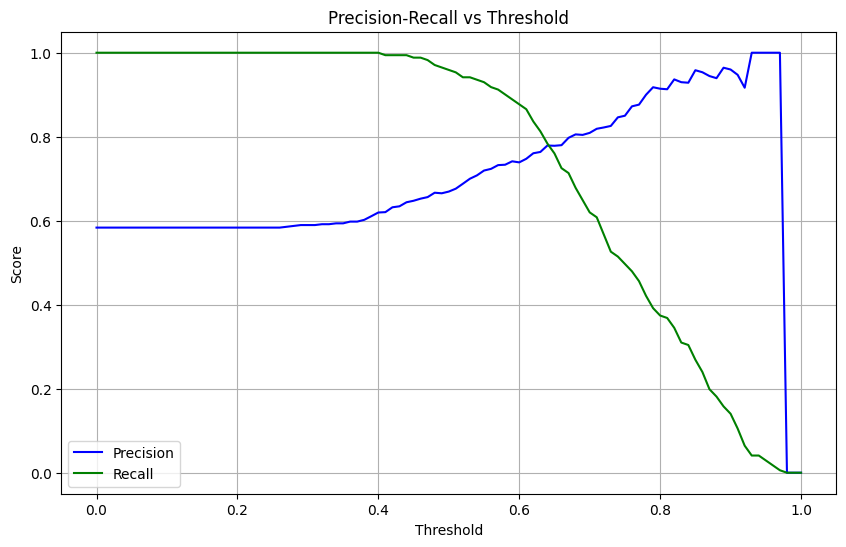

In [98]:
plt.figure(figsize=(10,6))
plt.plot(threshold, precision_values, label='Precision', color='blue')
plt.plot(threshold, recall_values, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [101]:
precision_values = np.array(precision_values)
recall_values = np.array(recall_values)

diff = np.abs(precision_values - recall_values)


In [112]:
diff = 0.01
intersection_threshold = None

for thresh, prec, rec in zip(threshold, precision_values, recall_values):
    if abs(prec - rec) <= diff:
        intersection = thresh
        print(f"Intersection point={thresh:.3f}")
        print(f"(Precision,Recall)=({prec:.3f},{rec:.3f})")
        break


Intersection point=0.640
(Precision,Recall)=(0.779,0.784)


In [131]:
precision_values = []
recall_values = []
f1score=[]
for t in threshold:
    y_pred_class = (y_val_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred_class, zero_division=0)
    recall = recall_score(y_val, y_pred_class, zero_division=0)
    f1 = (2 * precision * recall) / (precision + recall + 1e-8)  
    f1score.append(f1)


In [132]:
print(max(f1score))

0.8124999950598144


In [136]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

X_full = df_full_train.drop(columns=['converted'])
y_full = (df_full_train['converted'] != 0).astype(int)

for train_idx, val_idx in kf.split(X_full):
    X_tr = X_full.iloc[train_idx]
    X_va = X_full.iloc[val_idx]
    y_tr = y_full.iloc[train_idx]
    y_va = y_full.iloc[val_idx]

    dv = DictVectorizer(sparse=False)
    X_tr_enc = dv.fit_transform(X_tr.to_dict(orient='records'))
    X_va_enc = dv.transform(X_va.to_dict(orient='records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_tr_enc, y_tr)
    y_va_pred = model.predict_proba(X_va_enc)[:,1]
    auc = roc_auc_score(y_va, y_va_pred)
    scores.append(auc)

scores = np.array(scores)
print("Mean AUC:", round(scores.mean(), 4))
print("Std AUC:", round(scores.std(), 4))


Mean AUC: 0.8221
Std AUC: 0.0358


In [137]:
Cs = [0.000001, 0.001, 1]
results = {}
for C in Cs:
    fold_scores = []
    for train_idx, val_idx in kf.split(X_full):
        X_tr = X_full.iloc[train_idx]
        X_va = X_full.iloc[val_idx]
        y_tr = y_full.iloc[train_idx]
        y_va = y_full.iloc[val_idx]

        dv = DictVectorizer(sparse=False)
        X_tr_enc = dv.fit_transform(X_tr.to_dict(orient='records'))
        X_va_enc = dv.transform(X_va.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_tr_enc, y_tr)
        y_va_pred = model.predict_proba(X_va_enc)[:,1]
        auc = roc_auc_score(y_va, y_va_pred)
        fold_scores.append(auc)
    fold_scores = np.array(fold_scores)
    results[C] = (fold_scores.mean(), fold_scores.std())

In [138]:
for C,(m,s) in results.items():
    print(f"C={C}: mean={round(m,3)}, std={round(s,3)}")

C=1e-06: mean=0.56, std=0.024
C=0.001: mean=0.867, std=0.029
C=1: mean=0.822, std=0.036
